# Predicting polarity of Amazon Fine Food Review Data Set Using KNN

## Introduction

The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression.In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression

### We can implement a KNN model by following the below steps:

1.Load the data 

2.Initialise the value of k

3.For getting the predicted class, iterate from 1 to total number of training data points
    1.  Calculate the distance between test data and each row of training data. Here we will use Euclidean distance as our                     distance metric since it’s the most popular method. The other metrics that can be used are Chebyshev, cosine, etc.
    2.  Sort the calculated distances in ascending order based on distance values
    3.  Get top k rows from the sorted array
    4.  Get the most frequent class of these rows
    5.  Return the predicted class

## Objective:
#### To Predict the Polarity of Amazon Fine Food Review Using K-Nearst Neighbour Algorithm

#### Apply K-Nearest Neighbours Algorithm on
1. Bow(Bag of Words)
2. TF-IDF
3. Average Word2Vec
4. TF-IDF Word2Vec

### [Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review

### Steps :

#### We will perform following steps for classifying the review as positive or Negative:
##### 1.Importing data 
##### 2.Preparing that data
##### 3.Choosing a model
##### 4.Training
##### 5.Evaluation
##### 6.Hyperparameter tuning
##### 7.Prediction.

## 1. Importing Data and Useful Libraries

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn import preprocessing
from prettytable import PrettyTable
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit

In [3]:
#Loading Data
os.path.isfile("final.sqlite")
conn=sqlite3.connect("final.sqlite")
Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
conn.close()

##### Note:
The file "final.sqlite" contains preprossed data. Preproccessing steps like data cleaning, data deduplication, stemming, lammetizaion and removal of stop words have already been applied to the review text

## Breif Description of Data Set


In [4]:
print("Number of Reviews: ",Data["Text"].count())
print("Number of Users: ",len(Data["UserId"].unique())) 
print("Number of Products: ",len(Data["ProductId"].unique()))
print("Shape of Data: ",Data.shape)
print("\n",Data.columns)
print("Number of Attributes/Columns in data: 12") 
print("Number of Positive Reviews : ", Data['Score'].value_counts()[1])
print("Number of Negative Reviews : ", Data['Score'].value_counts()[0])

Number of Reviews:  364171
Number of Users:  243414
Number of Products:  65442
Shape of Data:  (364171, 12)

 Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')
Number of Attributes/Columns in data: 12
Number of Positive Reviews :  307061
Number of Negative Reviews :  57110


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

### Due to Limited Hardware Resource we will limit our analysis on 50000 data points for bruteforce implementaion and 20000 data points for kd tree implemenation only.

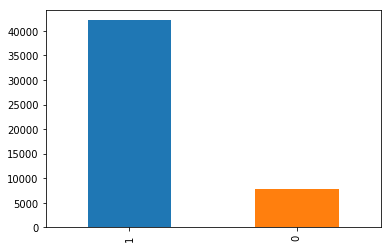

In [5]:
# randomly sampling 50k points for brute force
data = Data.sample(50000)
data.sort_values('Time',inplace=True)
data['Score'].value_counts().plot(kind='bar')

In [6]:
# X is a Feature Vector and y is the target/response/class variable
y = data['Score'].values
X = data['CleanedText'].values

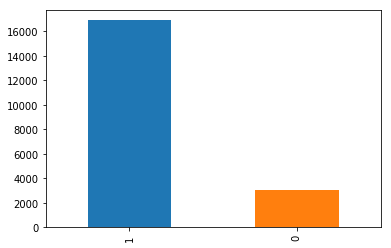

In [7]:
# randomly sampling 50k points for kd_tree
data1 = Data.sample(20000)
data1.sort_values('Time',inplace=True)
data1['Score'].value_counts().plot(kind='bar')

In [8]:
# X is a Feature Vector and y is the target/response/class variable
y1 = data['Score'].values
X1 = data['CleanedText'].values

### Defining Some functions

In [9]:
#knn brute_force

def knn_brute(X_train,y_train,neighbours):
    
    cv_scores=[]
    ts = TimeSeriesSplit(n_splits=10)
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        knn.fit(X_train,y_train)
        scores = cross_val_score(knn, X_train, y_train, cv=ts,scoring='roc_auc') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

In [1]:
#knn brute_force

def knn_kd(X_train,y_train,neighbours):
    
    cv_scores=[]
    ts = TimeSeriesSplit(n_splits=10)
    for k in neighbours:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
        knn.fit(X_train,y_train)
        scores = cross_val_score(knn, X_train, y_train, cv=ts,scoring='roc_auc') # returns accuracy for each of 10 folds
        cv_scores.append(scores.mean())
        
    mse = [1-x for x in cv_scores] # calculating misscalssification_error = 1 - accuracy for each K
    
    best_k = neighbours[mse.index(min(mse))] #returns k corresponding to minimum error
    
    return mse,best_k

In [11]:
#plot_neighbours vs error

def error_plot(neighbours,mse):
    
    plt.title('Error Plot')
    plt.xlabel('K')
    plt.ylabel('misscalssifiaction error')
    plt.plot(neighbours,mse)

In [12]:
#Plot ROC_AUC Curve

def plot_auc_roc(knn,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

In [13]:
# confusion_matrix

def confusionMatrix(knn,X_train,X_test,y_train,y_test):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, knn.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    print("*"*100)
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, knn.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [4]:
#table_brute
def table_brute():
    x = PrettyTable()
    x.field_names = ["Vectorizer", "Hyper parameter", "f1-score","Train AUC","Test AUC"]
    x.add_row(["Bags of Words",99,0.86,0.83,0.78])
    x.add_row(["TF-IDF",99,0.88,0.85,0.79])
    x.add_row(["Av. Word2Vec",91,0.89,0.87,0.82 ])
    x.add_row(["TF-IDF Word2Vec",89,0.85,0.50,0.77])
    print(x)

In [5]:
#table_kd
def table_kd():
    x = PrettyTable()
    x.field_names = ["Vectorizer", "Hyper parameter", "f1-score","Train AUC","Test AUC"]
    x.add_row(["Bags of Words",99,0.86,0.84,0.78])
    x.add_row(["TF-IDF",99,0.88,0.87,0.79])
    x.add_row(["Av. Word2Vec",87,0.89,0.87,0.83])
    x.add_row(["TF-IDF Word2Vec",27,0.50,0.50,0.77])
    print(x)

### Dividing the Data into Train and test set

In [16]:
#for bruteforce
from sklearn.model_selection import train_test_split

X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.33)

print("Shape of Train and Test  Data After Splitting")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shape of Train and Test  Data After Splitting
(33500,) (33500,)
(16500,) (16500,)


In [17]:
#for kd_tree
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train , y1_test = train_test_split(X1,y1,test_size=0.33)

print("Shape of Train and Test  Data After Splitting")
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

Shape of Train and Test  Data After Splitting
(33500,) (33500,)
(16500,) (16500,)


# Bags of Words(BoW)

### Brute Force Implementation

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train) #setting the vectorizer according to X_train

X_train_bow= vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

Shape of Train and Test Data After vectorizations
(33500, 22676) (33500,)
(16500, 22676) (16500,)


In [19]:
from sklearn import preprocessing
X_train_bow = preprocessing.normalize(X_train_bow)
X_test_bow = preprocessing.normalize(X_test_bow)

In [24]:
neighbours=np.arange(1,100,2)
mse,best_k = knn_brute(X_train_bow,y_train,neighbours)

#### Error Plot on test data

Best value of K found for Brute Force Implementaion is :  99


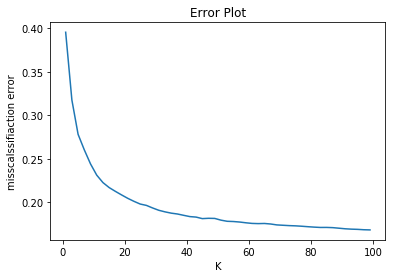

In [25]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Implementaion is : ",best_k)

#### Training the model and evaluting its performance on test data

In [26]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_bow, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

#### roc-auc curve

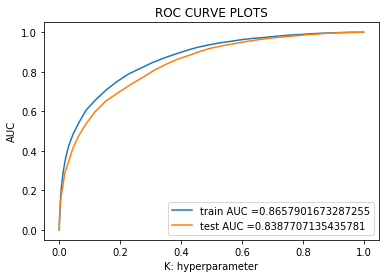

In [27]:
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X_train_bow,X_test_bow,y_train,y_test)

#### Confusion Matrix

Confusion Matrix for Train set


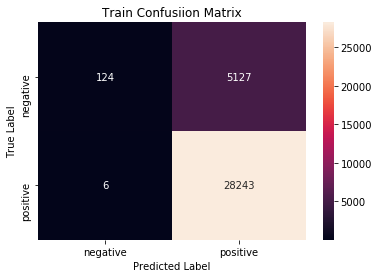

****************************************************************************************************
Confusion Matrix for Test set


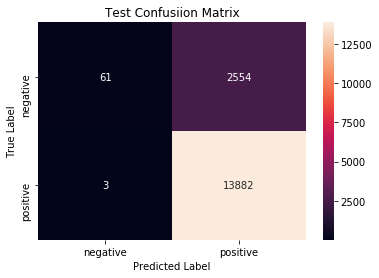

In [28]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X_train_bow,X_test_bow,y_train,y_test)

In [29]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_bow)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.95      0.02      0.05      2615
           1       0.84      1.00      0.92     13885

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.90      0.51      0.48     16500
weighted avg       0.86      0.85      0.78     16500



### KD_Tree Implementaion

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X1_train) #setting the vectorizer according to X_train

X1_train_bow= vectorizer.transform(X1_train)
X1_test_bow = vectorizer.transform(X1_test)

print("Shape of Train and Test Data After vectorizations")
print(X1_train_bow.shape, y1_train.shape)
print(X1_test_bow.shape, y1_test.shape)

Shape of Train and Test Data After vectorizations
(33500, 22582) (33500,)
(16500, 22582) (16500,)


In [31]:
from sklearn import preprocessing
X1_train_bow = preprocessing.normalize(X1_train_bow)
X1_test_bow = preprocessing.normalize(X1_test_bow)

Best value of K found for KD_Tree Implementaion is :  99


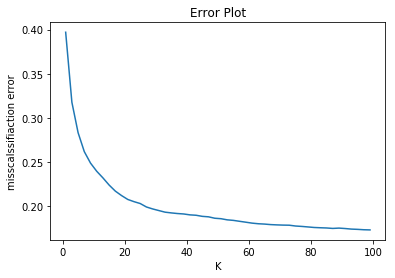

In [32]:
neighbours=np.arange(1,100,2)
mse,best_k = knn_kd(X1_train_bow,y1_train,neighbours)
error_plot(neighbours,mse)
print("Best value of K found for KD_Tree Implementaion is : ",best_k)

#### Training the model and evaluting its performance on test data

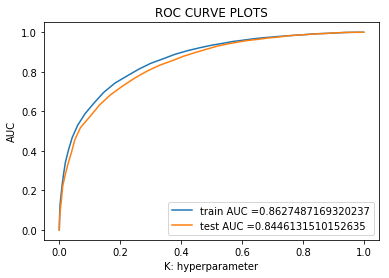

In [33]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X1_train_bow, y1_train)
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X1_train_bow,X1_test_bow,y1_train,y1_test)

#### Confusion Matrix

Confusion Matrix for Train set


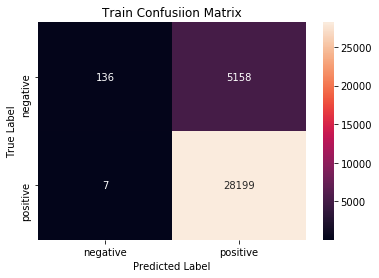

****************************************************************************************************
Confusion Matrix for Test set


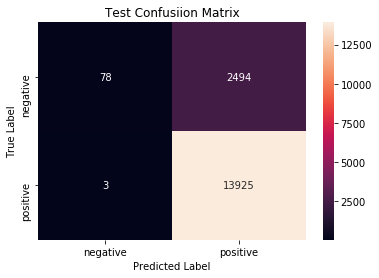

In [34]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X1_train_bow,X1_test_bow,y1_train,y1_test)

#### Classifiaction report 

In [35]:
print("Classification Report: \n")
prediction=neigh.predict(X1_test_bow)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.96      0.03      0.06      2572
           1       0.85      1.00      0.92     13928

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.91      0.52      0.49     16500
weighted avg       0.87      0.85      0.78     16500



# TF-IDF (2-grams)

### Brute Force Implementation

In [36]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_TF = vectorizer.transform(X_train)
X_test_TF = vectorizer.transform(X_test)

X_train_TF = preprocessing.normalize(X_train_TF)
X_test_TF = preprocessing.normalize(X_test_TF)

print("Shape of Train and Test Data After vectorizations")
print(X_train_TF.shape, y_train.shape)
print(X_test_TF.shape, y_test.shape)

Shape of Train and Test Data After vectorizations
(33500, 581735) (33500,)
(16500, 581735) (16500,)


In [37]:
neighbours= np.arange(1,100,2)
mse,best_k = knn_brute(X_train_TF,y_train,neighbours)

#### error plot

Best value of K found for Brute Force Implementaion is :  99


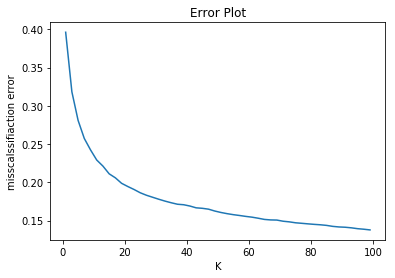

In [38]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Implementaion is : ",best_k)

### Training the model and evaluting its performance on test data

In [39]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_TF, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=99, p=2,
           weights='uniform')

#### roc-auc curve

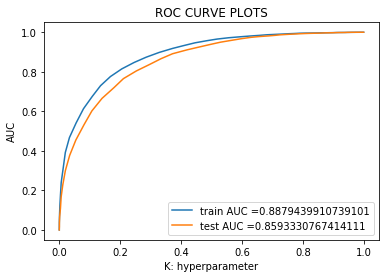

In [40]:
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X_train_TF,X_test_TF,y_train,y_test)

Confusion Matrix for Train set


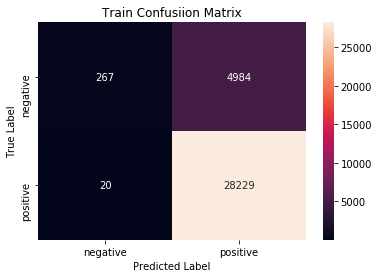

****************************************************************************************************
Confusion Matrix for Test set


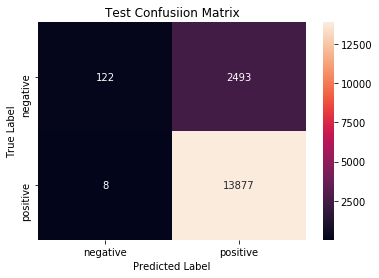

In [41]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X_train_TF,X_test_TF,y_train,y_test)

#### Classification report

In [42]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_TF)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.94      0.05      0.09      2615
           1       0.85      1.00      0.92     13885

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.89      0.52      0.50     16500
weighted avg       0.86      0.85      0.79     16500



### KD_Tree Implementaion

In [43]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X1_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X1_train_TF = vectorizer.transform(X1_train)
X1_test_TF = vectorizer.transform(X1_test)

X1_train_TF = preprocessing.normalize(X1_train_TF)
X1_test_TF = preprocessing.normalize(X1_test_TF)

print("Shape of Train and Test Data After vectorizations")
print(X1_train_TF.shape, y1_train.shape)
print(X1_test_TF.shape, y1_test.shape)

Shape of Train and Test Data After vectorizations
(33500, 583768) (33500,)
(16500, 583768) (16500,)


Best value of K found for KD_Tree Implementaion is :  99


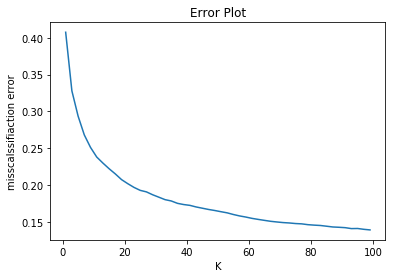

In [44]:
neighbours = np.arange(1,100,2)
mse,best_k = knn_kd(X1_train_TF,y1_train,neighbours)
error_plot(neighbours,mse)
print("Best value of K found for KD_Tree Implementaion is : ",best_k)

#### Training the model and evaluting its performance on test data

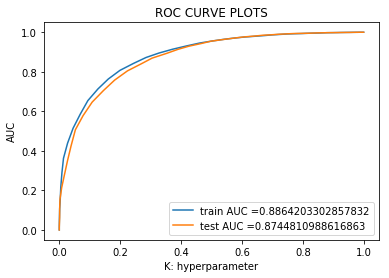

In [45]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X1_train_TF, y1_train)
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X1_train_TF,X1_test_TF,y1_train,y1_test)

#### Confusion matrix

Confusion Matrix for Train set


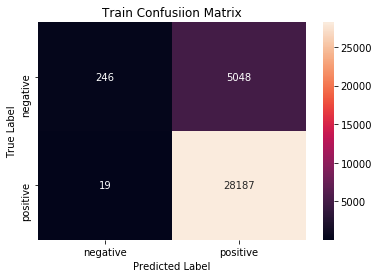

****************************************************************************************************
Confusion Matrix for Test set


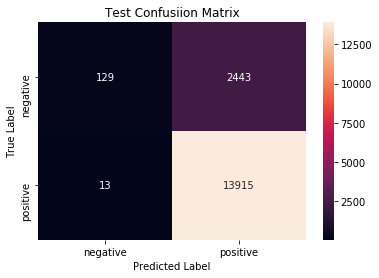

In [46]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X1_train_TF,X1_test_TF,y1_train,y1_test)

#### Classification Report

In [47]:
print("Classification Report: \n")
prediction=neigh.predict(X1_test_TF)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.91      0.05      0.10      2572
           1       0.85      1.00      0.92     13928

   micro avg       0.85      0.85      0.85     16500
   macro avg       0.88      0.52      0.51     16500
weighted avg       0.86      0.85      0.79     16500



# Word2Vec

In [18]:
#burteforce
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [19]:
#kd_tree
list_of_Train_sent1=[]
list_of_Test_sent1=[]

for sent in X1_train:
    list_of_Train_sent1.append(sent.split())
    
for sent in X1_test:
    list_of_Test_sent1.append(sent.split())

In [20]:
# bruteforce
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
Train_model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4) 

In [21]:
# kd_tree
#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
#import pickle
Train_model1=Word2Vec(list_of_Train_sent1,min_count=5,size=50, workers=4) 

## Average Word2Vec

In [55]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = Train_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [56]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=Train_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)

In [57]:
X_train_w2v = Train_vectors
X_test_w2v = Test_vectors

In [58]:
print(X_train_w2v.shape, y_train.shape)
print(X_test_w2v.shape, y_test.shape)

(33500, 50) (33500,)
(16500, 50) (16500,)


#### Brute Force Implementation

### Applying KNearestNeighbour Classifier

In [59]:
neighbours= np.arange(1,100,2)
mse,best_k = knn_brute(X_train_w2v,y_train,neighbours)

Best value of K found for Brute Force Implementaion is :  91


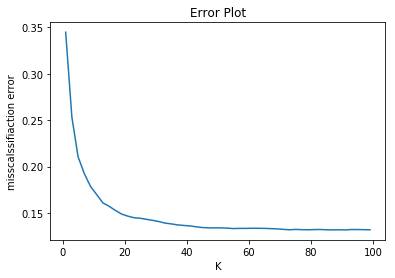

In [60]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Implementaion is : ",best_k)

### Training the model and evaluting its performance on test data

In [61]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_w2v, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=91, p=2,
           weights='uniform')

#### roc-auc curve

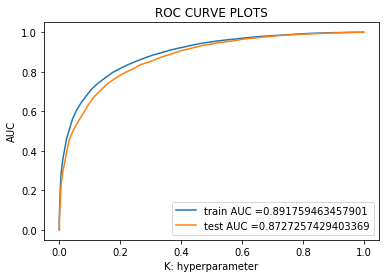

In [62]:
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X_train_w2v,X_test_w2v,y_train,y_test)

#### Confusion Matrix

Confusion Matrix for Train set


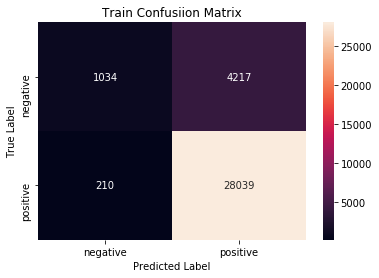

****************************************************************************************************
Confusion Matrix for Test set


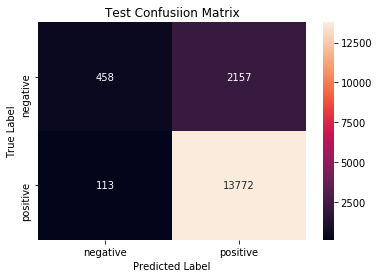

In [63]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X_train_w2v,X_test_w2v,y_train,y_test)

#### Classification report

In [64]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_w2v)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.18      0.29      2615
           1       0.86      0.99      0.92     13885

   micro avg       0.86      0.86      0.86     16500
   macro avg       0.83      0.58      0.61     16500
weighted avg       0.85      0.86      0.82     16500



#### KD_Tree Implementaion

In [65]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent1:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = Train_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [66]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent1:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=Train_model1.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)

In [67]:
X1_train_w2v = Train_vectors
X1_test_w2v = Test_vectors

In [68]:
print(X1_train_w2v.shape, y1_train.shape)
print(X1_test_w2v.shape, y1_test.shape)

(33500, 50) (33500,)
(16500, 50) (16500,)


#### finding the best k

Best value of K found for KD_Tree Implementaion is :  87


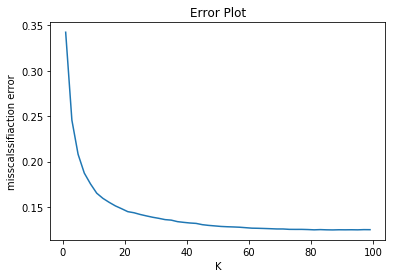

In [69]:
neighbours = np.arange(1,100,2)
mse,best_k = knn_kd(X1_train_w2v,y1_train,neighbours)
error_plot(neighbours,mse)
print("Best value of K found for KD_Tree Implementaion is : ",best_k)

#### Training the model and evaluting its performance on test data

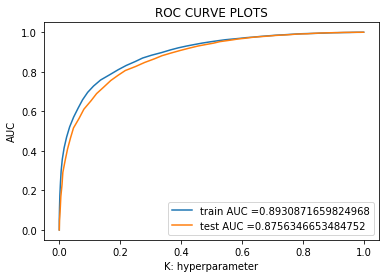

In [70]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X1_train_w2v, y1_train)
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X1_train_w2v,X1_test_w2v,y1_train,y1_test)

#### Confusion matrix

Confusion Matrix for Train set


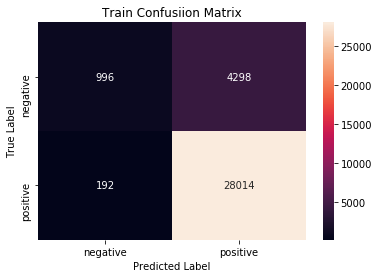

****************************************************************************************************
Confusion Matrix for Test set


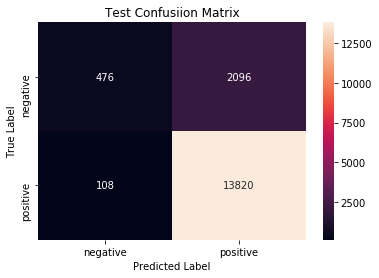

In [71]:
# plot confusion matrix to describe the performance of classifier.
confusionMatrix(neigh,X1_train_w2v,X1_test_w2v,y1_train,y1_test)

#### Classification report

In [72]:
print("Classification Report: \n")
prediction=neigh.predict(X1_test_w2v)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.82      0.19      0.30      2572
           1       0.87      0.99      0.93     13928

   micro avg       0.87      0.87      0.87     16500
   macro avg       0.84      0.59      0.61     16500
weighted avg       0.86      0.87      0.83     16500



## TF-IDF Weighted Word2Wec

#### Brute Force Implementation

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

model=TfidfVectorizer()
model.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_Train_TF = model.transform(X_train)
X_Test_TF = model.transform(X_test)

In [23]:
X_Train_TF = preprocessing.normalize(X_Train_TF)
X_Test_TF = preprocessing.normalize(X_Test_TF)

In [24]:
print("Shape of Train Data After TFIDF : ",X_Train_TF.shape)
print("Shape of Test Data After TFIDF : ",X_Test_TF.shape)

Shape of Train Data After TFIDF :  (33500, 22847)
Shape of Test Data After TFIDF :  (16500, 22847)


In [25]:
TFIDF_Feature=model.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

22847
['aaa', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaahhh', 'aaaaaahhhh', 'aaaahhhhhh', 'aaah', 'aaahhh', 'aaf', 'aafco', 'aahh', 'aalmost', 'aamazon', 'ab', 'aback', 'abalon', 'abando', 'abandon', 'abaolut', 'abbey']


In [26]:
Train_model.wv.most_similar('bad')

[('terribl', 0.7971003651618958),
 ('aw', 0.7710344791412354),
 ('wors', 0.7189821600914001),
 ('horribl', 0.715882420539856),
 ('okay', 0.6941101551055908),
 ('that', 0.6904090046882629),
 ('disgust', 0.6697205305099487),
 ('nasti', 0.6678438782691956),
 ('funni', 0.6667054891586304),
 ('matter', 0.6639704704284668)]

In [27]:
import numpy as np
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in list_of_Train_sent:
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=Train_model.wv[word]
            tfidf_vec=X_Train_TF[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec)
    row+=1

In [28]:
import numpy as np

Test_TFIDF_W2V_Vectors=[]
row=0
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=Train_model.wv[word]
            tfidf_vec=X_Test_TF(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

In [29]:
X_train_w2v=Train_TFIDF_W2V_Vectors
X_test_w2v=Test_TFIDF_W2V_Vectors

In [30]:

X_train_w2v = preprocessing.normalize(X_train_w2v)
X_test_w2v = preprocessing.normalize(X_test_w2v)

### Applying KNearestNeighbour Classifier

In [31]:
neighbours= np.arange(1,100,4)
mse,best_k = knn_brute(X_train_w2v,y_train,neighbours)

Best value of K found for Brute Force Implementaion is :  89


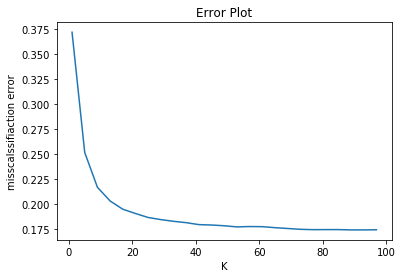

In [32]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Implementaion is : ",best_k)

In [33]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='brute')
neigh.fit(X_train_w2v, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=89, p=2,
           weights='uniform')

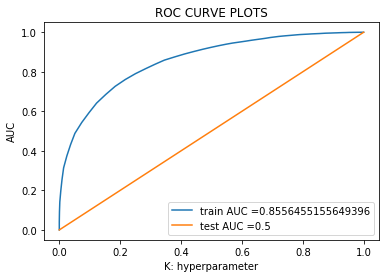

In [34]:
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X_train_w2v,X_test_w2v,y_train,y_test)

#### Confusion Matrix

Confusion Matrix for Train set


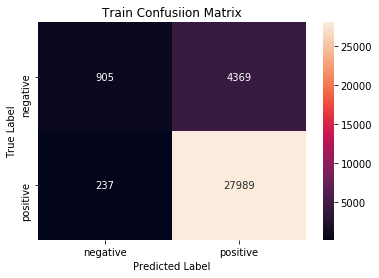

****************************************************************************************************
Confusion Matrix for Test set


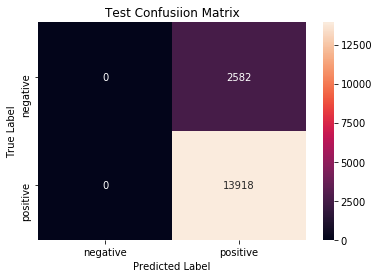

In [35]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X_train_w2v,X_test_w2v,y_train,y_test)

#### Classification report

In [36]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_w2v)
print(classification_report(y_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2582
           1       0.84      1.00      0.92     13918

   micro avg       0.84      0.84      0.84     16500
   macro avg       0.42      0.50      0.46     16500
weighted avg       0.71      0.84      0.77     16500



### KD Tree implimplementaion

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

model=TfidfVectorizer()
model.fit(X1_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_Train_TF = model.transform(X1_train)
X_Test_TF = model.transform(X1_test)

In [38]:
print("Shape of Train Data After TFIDF : ",X_Train_TF.shape)
print("Shape of Test Data After TFIDF : ",X_Test_TF.shape)

Shape of Train Data After TFIDF :  (33500, 22681)
Shape of Test Data After TFIDF :  (16500, 22681)


In [39]:
import numpy as np
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in list_of_Train_sent:
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=Train_model.wv[word]
            tfidf_vec=X_Train_TF[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec)
    row+=1

In [40]:
import numpy as np

Test_TFIDF_W2V_Vectors=[]
row=0
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=Test_model.wv[word]
            tfidf_vec=X_Test_TF(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

In [41]:
X_train_w2v=Train_TFIDF_W2V_Vectors
X_test_w2v=Test_TFIDF_W2V_Vectors

In [42]:
neighbours= np.arange(1,100,2)
mse,best_k = knn_kd(X_train_w2v,y1_train,neighbours)

#### Error Plot

Best value of K found for Brute Force Implementaion is :  27


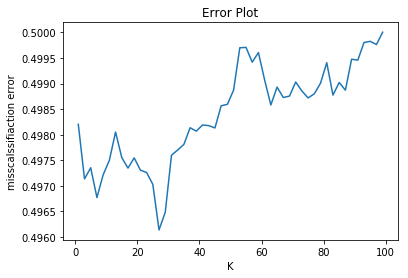

In [43]:
error_plot(neighbours,mse)
print("Best value of K found for Brute Force Implementaion is : ",best_k)

#### Training the model

In [44]:
neigh = KNeighborsClassifier(n_neighbors = best_k,algorithm='kd_tree')
neigh.fit(X_train_w2v, y1_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=27, p=2,
           weights='uniform')

#### Roc-Auc Curve

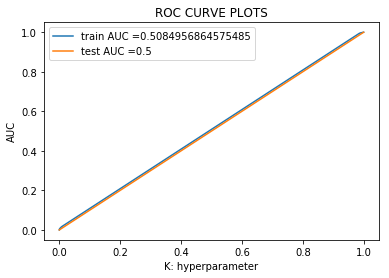

In [45]:
#Tesing and plotting roc_auc
plot_auc_roc(neigh,X_train_w2v,X_test_w2v,y1_train,y1_test)

#### Confusion matrix

Confusion Matrix for Train set


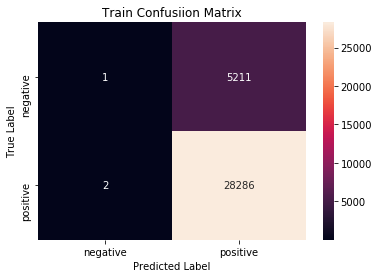

****************************************************************************************************
Confusion Matrix for Test set


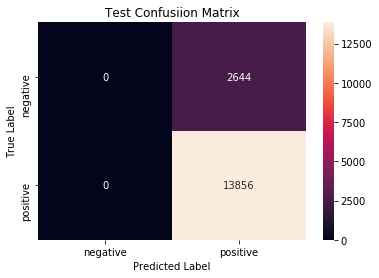

In [46]:
# plot confusion matrix to describe the performance of classifier.

confusionMatrix(neigh,X_train_w2v,X_test_w2v,y1_train,y1_test)

#### Classification report

In [47]:
print("Classification Report: \n")
prediction=neigh.predict(X_test_w2v)
print(classification_report(y1_test, prediction))

Classification Report: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2644
           1       0.84      1.00      0.91     13856

   micro avg       0.84      0.84      0.84     16500
   macro avg       0.42      0.50      0.46     16500
weighted avg       0.71      0.84      0.77     16500



#### Brute-Force  Summary

In [6]:
table_brute()

+-----------------+-----------------+----------+-----------+----------+
|    Vectorizer   | Hyper parameter | f1-score | Train AUC | Test AUC |
+-----------------+-----------------+----------+-----------+----------+
|  Bags of Words  |        99       |   0.86   |    0.83   |   0.78   |
|      TF-IDF     |        99       |   0.88   |    0.85   |   0.79   |
|   Av. Word2Vec  |        91       |   0.89   |    0.87   |   0.82   |
| TF-IDF Word2Vec |        89       |   0.85   |    0.5    |   0.77   |
+-----------------+-----------------+----------+-----------+----------+


#### KD-Tree Summary

In [7]:
table_kd()

+-----------------+-----------------+----------+-----------+----------+
|    Vectorizer   | Hyper parameter | f1-score | Train AUC | Test AUC |
+-----------------+-----------------+----------+-----------+----------+
|  Bags of Words  |        99       |   0.86   |    0.84   |   0.78   |
|      TF-IDF     |        99       |   0.88   |    0.87   |   0.79   |
|   Av. Word2Vec  |        87       |   0.89   |    0.87   |   0.83   |
| TF-IDF Word2Vec |        27       |   0.5    |    0.5    |   0.77   |
+-----------------+-----------------+----------+-----------+----------+


# Take Aways

##### 1. TF-IDF Word2Vec is overfitting on train data
##### 2. TF-IDF Word2Vec is highly biased on test data
##### 3. Poor performance of Word2Vec Vecorizer can be attributed to lack of sufficiant data. Since Word2Vec need a huge corpus of data to                            establish some meaningful relationship among the words but I couldnot do so due to lack of hardware resource
##### 4. Since dimensions is very high KD Tree implementation is not giving any improvement over brute force
##### 5. Overall accuracy for KNN is not satisfactory so we need to choose other model and compare the results